In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil
import time
import datetime

In [2]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.13.0+cu116


In [3]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/ML-Final-Project/") # Remember to add this shared folder as shortcut to your own google drive
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1CdXXOINmvPb172gUSrPGGw2VmjgV5Mmb/ML-Final-Project'

In [4]:
# Copied from https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch

def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        #transforms.CenterCrop((128,128))
        transforms.RandomCrop((512,512),pad_if_needed=True)
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 128-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 128-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


In [5]:
# Recall that we have resized the images and saved them into

train_folder = 'whole-1000/'
# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read whole-1000/


In [7]:
training_folder_name = 'whole-1000/'

# All images are 128x128 pixels
img_size = (512,512)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['drawing', 'painting', 'photograph', 'photomechanical print']


In [8]:
#Alina: AlexNet
#https://pytorch.org/vision/main/_modules/torchvision/models/alexnet.html
from functools import partial
from typing import Any, Optional
import torch
import torch.nn as nn
from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
#from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._api import Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface

__all__ = ["AlexNet", "AlexNet_Weights", "alexnet"]

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
class AlexNet_Weights(WeightsEnum):
      IMAGENET1K_V1 = Weights(
      url="https://download.pytorch.org/models/alexnet-owt-7be5be79.pth",
      transforms=partial(ImageClassification, crop_size=224),
      meta={
              "num_params": 61100840,
              "min_size": (63, 63),
              "categories": _IMAGENET_CATEGORIES,
              "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#alexnet-and-vgg",
              "_metrics": {
              "ImageNet-1K": {
                  "acc@1": 56.522,
                  "acc@5": 79.066,
              }
          },
          "_ops": 0.714,
          "_weight_size": 233.087,
          "_docs": """
              These weights reproduce closely the results of the paper using a simplified training recipe.
          """,
      },
  )
      DEFAULT = IMAGENET1K_V1

def alexnet(*, weights: Optional[AlexNet_Weights] = None, progress: bool = True, **kwargs: Any) -> AlexNet:
    weights = AlexNet_Weights.verify(weights)

    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = AlexNet(**kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = AlexNet(num_classes=len(classes)).to(device)
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# Train Model

def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [10]:
# Test Model

def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [11]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 35
print('Training on', device)
for epoch in range(1, epochs + 1):
        time1 = time.time() #timekeeping
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        time2 = time.time() #timekeeping
        print('Elapsed time for epoch:',time2 - time1,'s')
        print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
        print()
        if epoch % 4 == 1:
          model_save_path = os.path.join("saved_models", "alexnet_{}_epoch_{}".format(datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S"), epoch))
          torch.save(model.state_dict(), model_save_path)


Training on cuda
Epoch: 1
	Training batch 1 Loss: 1.385520
	Training batch 2 Loss: 1.383464
	Training batch 3 Loss: 1.357821
	Training batch 4 Loss: 1.272266
	Training batch 5 Loss: 1.141287
	Training batch 6 Loss: 1.135630
	Training batch 7 Loss: 1.289602
	Training batch 8 Loss: 0.944447
	Training batch 9 Loss: 1.175494
	Training batch 10 Loss: 1.082425
	Training batch 11 Loss: 1.070201
	Training batch 12 Loss: 1.024616
	Training batch 13 Loss: 1.049244
	Training batch 14 Loss: 1.022597
	Training batch 15 Loss: 1.091811
	Training batch 16 Loss: 0.944066
	Training batch 17 Loss: 0.924965
	Training batch 18 Loss: 0.991336
	Training batch 19 Loss: 0.926362
	Training batch 20 Loss: 0.992487
	Training batch 21 Loss: 1.049998
	Training batch 22 Loss: 1.065823
	Training batch 23 Loss: 1.006365
	Training batch 24 Loss: 1.003566
Training set: Average loss: 1.097141
Validation set: Average loss: 1.020925, Accuracy: 659/1274 (52%)

Elapsed time for epoch: 1997.143038034439 s
ETA of completion: 1

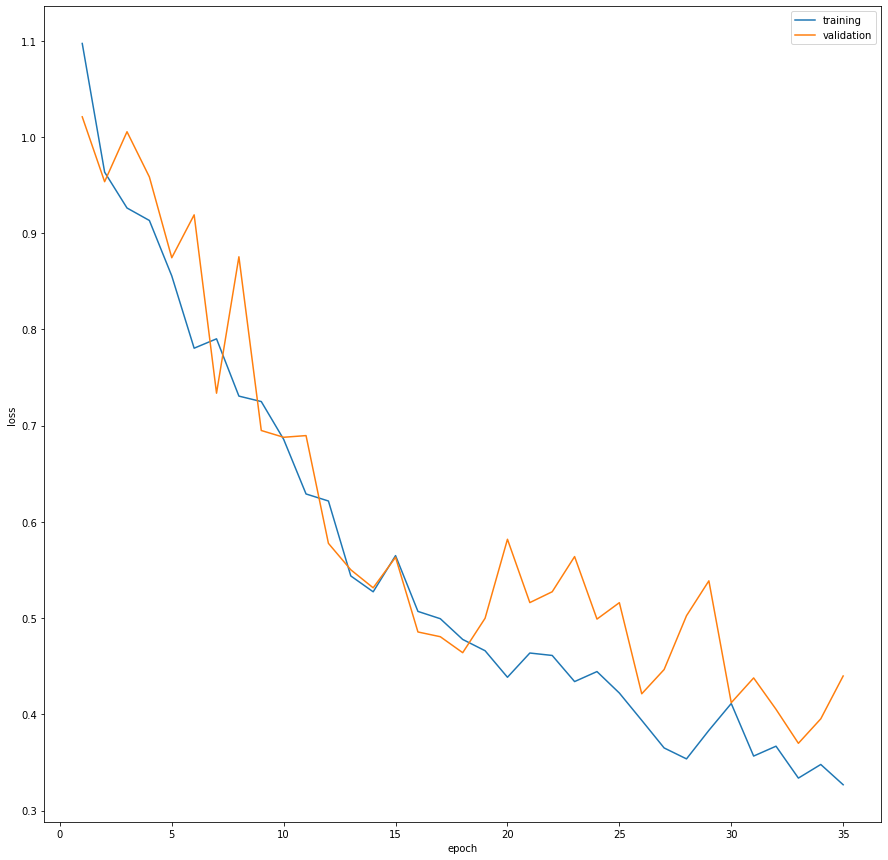

In [12]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
# We took the model trained at epoch 33 because the validation loss increased sharply at the two final epoches
model.load_state_dict(torch.load(model_save_path))
print(model)

Getting predictions from test set...


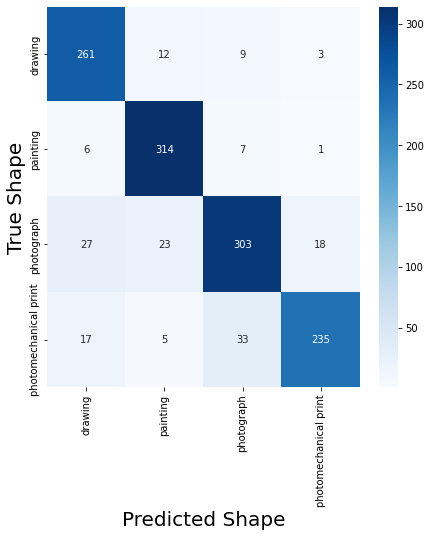

In [23]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model(data).cpu().data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

In [24]:
accuracy_score(truelabels, predictions)

0.8736263736263736